# Keras starter kit [full training set, UNet]

## Setup

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torchvision
import datetime
# import cupy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
import pytorch_lightning.plugins
from skimage.transform import resize as resize_ski
from pytorch_lightning.strategies.ddp import DDPStrategy
from pytorch_lightning.loggers import WandbLogger
import os


from scipy.ndimage import distance_transform_edt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
from sklearn.model_selection import KFold
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data


# Data config
# DATA_DIR = '/kaggle/input/vesuvius-challenge-ink-detection/'
# DATA_DIR = '/home/fummicc1/codes/competitions/kaggle-ink-detection'
DATA_DIR = '/home/fummicc1/codes/Kaggle/kaggle-ink-detection'
BUFFER = 128 # Half-size of papyrus patches we'll use as model inputs
# Z_LIST = list(range(0, 20, 5)) + list(range(22, 34))  # Offset of slices in the z direction
Z_LIST = (
    list(range(0, 24, 8)) + list(range(24, 36, 2)) + list(range(36, 64, 10))
)  # Offset of slices in the z direction
Z_DIM = len(Z_LIST)  # Number of slices in the z direction. Max value is 64 - Z_START
SHARED_HEIGHT = None  # Max height to resize all papyrii

# Model config
BATCH_SIZE = 64

# backbone = "mit_b2"
# backbone = "efficientnet-b5"
# backbone = "se_resnext101_32x4d"
backbone = "resnext50_32x4d"
# backbone = "resnet50"

device = torch.device("cuda")
threshold = 0.5
num_workers = 8
exp = 1e-7
mask_padding = 400

num_epochs = 50
lr = 5e-4

pytorch_lightning.seed_everything(seed=42)
torch.set_float32_matmul_precision('high')

Global seed set to 42


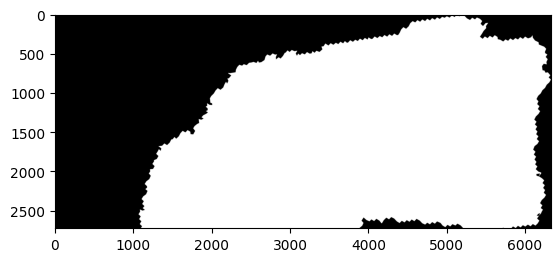

In [2]:
# plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap="gray")
# plt.imshow(Image.open(DATA_DIR + "/train/2/ir.png"), cmap="gray")
# plt.imshow(Image.open(DATA_DIR + "/train/3/ir.png"), cmap="gray")
plt.imshow(Image.open(DATA_DIR + "/test/a/mask.png"), cmap="gray")
# plt.imshow(Image.open(DATA_DIR + "/test/b/mask.png"), cmap="gray")

## Load up the training data

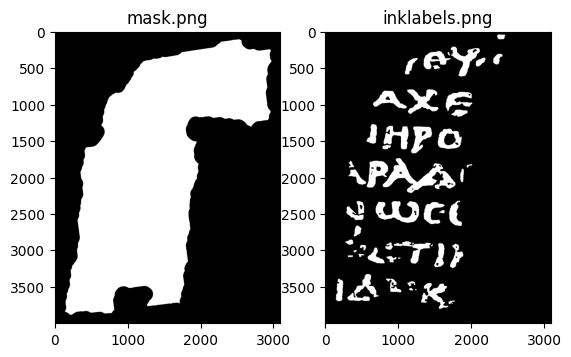

In [3]:
def resize(img):
    current_height, current_width = img.shape    
    aspect_ratio = current_width / current_height
    if SHARED_HEIGHT is None:
        return img
    new_height = SHARED_HEIGHT
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, new_height)
    # (W, H)の順で渡すが結果は(H, W)になっている
    img = cv2.resize(img, new_size)
    return img

def load_mask(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/mask.png", 0) // 255
    img = np.pad(img, 1, constant_values=0)
    dist = distance_transform_edt(img)
    img[dist <= mask_padding] = 0
    img = img[1:-1, 1:-1]
    img = resize(img)    
    return img


def load_labels(split, index):
    img = cv2.imread(f"{DATA_DIR}/{split}/{index}/inklabels.png", 0) // 255
    img = resize(img)
    return img


masks = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(masks, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [4]:
# input shape: (H, W, C)
def rotate90(volume: np.ndarray, k=None, reverse=False):    
    if k:
        volume = np.rot90(volume, k)
    else:
        volume = np.rot90(volume, 1 if not reverse else 3)
    height = volume.shape[0]
    width = volume.shape[1]
    new_height = SHARED_HEIGHT
    new_width = int(new_height * width / height)
    if len(volume.shape) == 2:
        return cv2.resize(volume, (new_width, new_height))
    return resize_ski(volume, (new_height, new_width, volume.shape[2]))

In [5]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    all = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))
    z_slices_fnames = [all[i] for i in range(len(all)) if i in Z_LIST]
    assert len(z_slices_fnames) == Z_DIM
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = cv2.imread(filename, -1)
        img = resize(img)
        # img = (img / (2 ** 8)).astype(np.uint8)
        img = img.astype(np.float32) // 255
        z_slices.append(img)
    return np.stack(z_slices, axis=-1)

In [ ]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

# volume = np.concatenate([volume_train_1, volume_train_2, volume_train_3], axis=1)
# volume = np.concatenate([volume_train_1, volume_train_2], axis=1)
# print(f"total volume: {volume.shape}")

## Create a dataset in the input volume


In [ ]:
def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]] > 0


In [ ]:
def generate_locations_ds(volume, mask, skip_zero):
    is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

    # Create a list to store train locations
    locations = []

    # Generate train locations
    volume_height, volume_width = volume.shape[:-1]

    for y in range(BUFFER, volume_height - BUFFER, int(BUFFER / 2)):
        for x in range(BUFFER, volume_width - BUFFER, int(BUFFER / 2)):
            if skip_zero and np.all(volume[y - BUFFER : y + BUFFER, x - BUFFER : x + BUFFER] == 0):
                continue
            if is_in_mask_train((y, x)):
                locations.append((y, x))

    # Convert the list of train locations to a PyTorch tensor
    locations_ds = np.stack(locations, axis=0)
    return locations_ds

## Visualize some training patches

Sanity check visually that our patches are where they should be.

In [ ]:
def extract_subvolume(location, volume):
    global printed
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :].astype(np.float32)
    
    return subvolume

In [ ]:
import torch
import numpy as np
x = torch.from_numpy(np.array([[[[1, 2], [2, 9],]]]))
shape = x.shape
print(x.shape)
x=[x,*[torch.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
x = torch.cat(x, dim=1)
print(x.shape)
x=x.reshape(4,shape[0],*shape[2:])
print(x.shape)
x=[torch.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
x=torch.stack(x,dim=0)
print(x.shape)
x.mean(0, dtype=torch.float32, keepdim=True).shape

In [ ]:
tc = torch
def TTA(x:tc.Tensor,model:nn.Module):
    #x.shape=(batch,c,h,w)
    shape=x.shape
    x=[x,*[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
    x=tc.cat(x,dim=0)
    x=model(x)
    x=torch.sigmoid(x)
    x=x.reshape(4,shape[0], 1 ,*shape[2:])
    x=[tc.rot90(x[i],k=4-i,dims=(-2,-1)) for i in range(4)]
    x=tc.stack(x,dim=0)
    return x.mean(0)

## SubvolumeDataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

from albumentations.core.transforms_interface import ImageOnlyTransform

class SubvolumeDataset(Dataset):
    def __init__(self, locations, volume, labels, buffer, is_train: bool, return_location: bool = False):
        self.locations = locations
        self.volume = volume
        self.labels = labels        
        self.buffer = buffer
        self.is_train = is_train
        self.return_location = return_location

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        label = None
        location = np.array(self.locations[idx])
        y, x = location[0], location[1]

        subvolume = extract_subvolume(location, self.volume)
        
        if self.labels is not None:
            label = self.labels[y - self.buffer:y + self.buffer, x - self.buffer:x + self.buffer]            
            label = np.stack([label], axis=-1)            
        
        if self.is_train and label is not None:
            transformed = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomScale(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(p=0.75),
                A.OneOf(
                    [
                        A.GaussNoise(var_limit=[10, 50]),
                        A.GaussianBlur(),
                        A.MotionBlur(),
                    ],
                    p=0.4,
                ),
                A.CoarseDropout(
                    max_holes=1,
                    max_width=int(self.buffer * 0.3),
                    max_height=int(self.buffer * 0.3),
                    mask_fill_value=0,
                    p=0.5,
                ),
                A.Resize(height=self.buffer * 2, width=self.buffer * 2),
            ])(image=subvolume, mask=label)
            subvolume = transformed["image"]
            label = transformed["mask"]
            subvolume = np.transpose(subvolume, (2, 0, 1))
            label = np.transpose(label, (2, 0, 1))
            subvolume /= 255.
            subvolume = (subvolume - 0.45) / 0.225
        else:
            if label is None:
                subvolume = np.transpose(subvolume, (2, 0, 1))
                subvolume /= 255.
                subvolume = (subvolume - 0.45) / 0.225
            else:
                # print("subvolume in val dataset (before aug)", subvolume, file=open("before-val-aug.log", "w")) 
                subvolume = np.transpose(subvolume, (2, 0, 1))
                label = np.transpose(label, (2, 0, 1))
                subvolume /= 255.
                subvolume = (subvolume - 0.45) / 0.225
        if self.return_location:
            return subvolume, location
        return subvolume, label        

## Visualize validation dataset patches

Note that they are partially overlapping, since the stride is half the patch size.

In [ ]:
def visualize_dataset_patches(locations_ds, labels, mode: str, fold = 0):
    fig, ax = plt.subplots()
    ax.imshow(labels)

    for y, x in locations_ds:
        patch = patches.Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(patch)
    plt.savefig(f"fold-{fold}-{mode}.png")
    plt.show()    

## Compute a trivial baseline

This is the highest validation score you can reach without looking at the inputs.
The model can be considered to have statistical power only if it can beat this baseline.

## Dataset check

In [ ]:
sample_locations = generate_locations_ds(volume_train_1, mask_train_1, skip_zero=True)
sample_ds = SubvolumeDataset(
    sample_locations,
    volume_train_1,
    labels_train_1,
    BUFFER,
    is_train=True,
)

img = sample_ds[150][0][10, :, :]
plt.imshow(img)

fig, ax = plt.subplots(figsize=(8, 6))

ax.imshow(labels_train_1)

y, x = sample_locations[150]
patch = patches.Rectangle([x - BUFFER, y - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()    

fig, ax = plt.subplots(Z_DIM, 1, figsize=(12, 24))

for i in range(Z_DIM):
    img, _ = sample_ds[150]
    img = img[i, :, :]
    ax[i].hist(img.flatten(), bins=1000)  # Plot histogram of the flattened data
    ax[i].set_title(f"Histogram of Channel {i}")  # Add title to the plot    
fig.tight_layout()
fig.show()

## Model

In [ ]:
def dice_coef_torch(prob_preds, targets, beta=0.5, smooth=1e-5):
    # No need to binarize the predictions
    # prob_preds = torch.sigmoid(preds)

    # flatten label and prediction tensors
    prob_preds = prob_preds.view(-1).float()
    targets = targets.view(-1).float()

    intersection = (prob_preds * targets).sum()

    dice = ((1 + beta**2) * intersection + smooth) / ((beta**2) * prob_preds.sum() + targets.sum() + smooth)

    return dice



class Model(pl.LightningModule):
    training_step_outputs = []
    validation_step_outputs = []
    test_step_outputs = [[], []]

    def __init__(self, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()

        self.model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            # encoder_weights=None,
            encoder_depth=5,
            decoder_channels=[512, 256, 128, 64, 32,],
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )

        self.segmentation_loss_fn = smp.losses.TverskyLoss(
            smp.losses.BINARY_MODE, 
            log_loss=False, 
            from_logits=True, 
            smooth=1e-6,
            alpha=0.5 ,
            beta=0.7,
        )
        # self.segmentation_loss_fn = dice_coef_torch
        # self.classification_loss_fn = smp.losses.SoftCrossEntropyLoss()

    def forward(self, image, stage):        
        if stage != "train":
            mask = TTA(image, self.model)
        else:
            mask = self.model(image)
            mask = torch.sigmoid(mask)
        return mask

    def shared_step(self, batch, stage):
        subvolumes, labels = batch

        image, labels = subvolumes.float(), labels.float()        
        assert image.ndim == 4
        
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0
        
        # print("labels", labels.max(), labels.min())

        assert labels.max() <= 1.0 and labels.min() >= 0

        segmentation_out = self.forward(image, stage)

        loss = self.segmentation_loss_fn(segmentation_out, labels)

        prob_mask = segmentation_out
        pred_mask = (prob_mask > threshold).float()

        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), labels.long(), mode="binary"
        )

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        loss = torch.mean(torch.Tensor([x["loss"] for x in outputs]))

        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_loss": loss,
            f"{stage}_tp": tp.sum().int().item(),
            f"{stage}_fp": fp.sum().int().item(),
            f"{stage}_fn": fn.sum().int().item(),
            f"{stage}_tn": tn.sum().int().item(),
        }

        self.log_dict(metrics, prog_bar=True, sync_dist=True)

    def training_step(self, batch, batch_idx):
        out = self.shared_step(batch, "train")
        self.training_step_outputs.append(out)
        return out

    def on_train_epoch_end(self):
        out = self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()
        return out

    def validation_step(self, batch, batch_idx):
        out = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(out)
        return out

    def on_validation_epoch_end(self):
        out = self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return out

    def test_step(self, batch, batch_idx):
        global predictions_map, predictions_map_counts

        patch_batch, loc_batch = batch

        loc_batch = loc_batch.long()
        patch_batch = patch_batch.float()
        predictions: torch.Tensor = self.forward(patch_batch, "test")
 
        predictions = torch.permute(predictions, (0, 2, 3, 1)).squeeze(dim=-1)
        predictions = (
            predictions.cpu().numpy()
        )
        loc_batch = loc_batch.cpu().numpy()
        
        self.test_step_outputs[0].extend(loc_batch)
        self.test_step_outputs[1].extend(predictions)
        return loc_batch, predictions


    def on_test_epoch_end(self):
        global predictions_map, predictions_map_counts

        locs = np.array(self.test_step_outputs[0])
        preds = np.array(self.test_step_outputs[1])
        print("locs", locs.shape)
        print("preds", preds.shape)

        new_predictions_map = np.zeros_like(predictions_map[:, :, 0])
        new_predictions_map_counts = np.zeros_like(predictions_map_counts[:, :, 0])

        for (y, x), pred in zip(locs, preds):
            new_predictions_map[
                y - BUFFER : y + BUFFER, x - BUFFER : x + BUFFER
            ] += pred
            new_predictions_map_counts[
                y - BUFFER : y + BUFFER, x - BUFFER : x + BUFFER
            ] += 1
        
        new_predictions_map /= new_predictions_map_counts + exp
        new_predictions_map = new_predictions_map[:, :, np.newaxis]
        predictions_map = np.concatenate(
            [predictions_map, new_predictions_map], axis=-1
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=lr)
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.05, patience=5,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "valid_loss"},
        }


In [ ]:
volume_train_1.shape, labels_train_1.shape, mask_train_1.shape

# !export CUDA_LAUNCH_BLOCKING=1
# !export TORCH_USE_CUDA_DSA=1

In [ ]:

k_folds = 3
kfold = KFold(
    n_splits=k_folds,
    shuffle=True
)
data_list = [
    (volume_train_1, labels_train_1, mask_train_1),
    (volume_train_2, labels_train_2, mask_train_2),
    (volume_train_3, labels_train_3, mask_train_3),    
]

for fold, (train_data, val_data) in enumerate(kfold.split(data_list)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    print("train_data", train_data)
    print("val_data", val_data)
    one = data_list[train_data[0]]
    two = data_list[train_data[1]]    
    train_volume = np.concatenate([one[0], two[0]], axis=1)
    train_label = np.concatenate([one[1], two[1]], axis=1)
    train_mask = np.concatenate([one[2], two[2]], axis=1)
    val_volume, val_label, val_mask = data_list[val_data[0]]    

    train_locations_ds = generate_locations_ds(train_volume, train_mask, skip_zero=True)
    val_location_ds = generate_locations_ds(val_volume, val_mask, skip_zero=False)       

    visualize_dataset_patches(train_locations_ds, train_label, "train", fold)
    visualize_dataset_patches(val_location_ds, val_label, "val", fold)
    
    # Init the neural network
    model = Model(
        encoder_name=backbone,
        in_channels=Z_DIM,
        out_classes=1,
    )

    # Initialize a trainer
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        devices="auto",
        accelerator="auto",
        # strategy="ddp_find_unused_parameters_false",
        # strategy="ddp_fork",
        logger=WandbLogger(
            name=f"2.5dimension-{datetime.datetime.now()}"
        ),
    )
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_ds = SubvolumeDataset(
        train_locations_ds,
        train_volume,
        train_label,
        BUFFER,
        is_train=True
    )
    val_ds = SubvolumeDataset(
        val_location_ds,
        val_volume,
        val_label,
        BUFFER,
        is_train=False,
    )

    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
        train_ds, 
        batch_size=BATCH_SIZE,
        num_workers=num_workers,
        shuffle=True,
    )
    val_loader = torch.utils.data.DataLoader(
        val_ds, 
        batch_size=BATCH_SIZE,
        num_workers=num_workers,
        shuffle=False,
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)
